In [140]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import astropy.constants as c
from astroquery.vizier import Vizier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
tf.config.set_visible_devices([], 'GPU')
pd.set_option('display.max_columns', None)

### Dataset
We will download a catalog of main sequence stars using astroquery.Vizier, and train a neural network to predict the effective temperature of the stars from their luminosity based on the Hertzsprung-Russell relation. To ensure that the catalog is the same every time, we use the code below to save it into a csv file. 

In [ ]:
# # Download a catalog of stars from Vizier
# vizier = Vizier(columns=['Lum', 'BP-RP', 'Teff'], column_filters={'Lum': ' > 0', 'Teff': ' > 0'})
# vizier.ROW_LIMIT = 10000
# catalog = vizier.get_catalogs('I/345')[0]

# # Save as CSV
# catalog = catalog.to_pandas()
# catalog.to_csv('catalog.csv', index=False)

### Data Preparation

In [114]:
# Load data
data = pd.read_csv('catalog.csv')
data['logL'] = np.log10(data['Lum'])
data['logT'] = np.log10(data['Teff'])

# Define inputs and output
x = data['logL'].values
y = data['logT'].values

# Normalize inputs
x = (x - np.min(x, axis=0)) / (np.max(x, axis=0) - np.min(x, axis=0))

# Reshuffle data
np.random.seed(1453)
shuffle_index = np.random.permutation(len(x))
x = x[shuffle_index]
y = y[shuffle_index]

### Network Definition

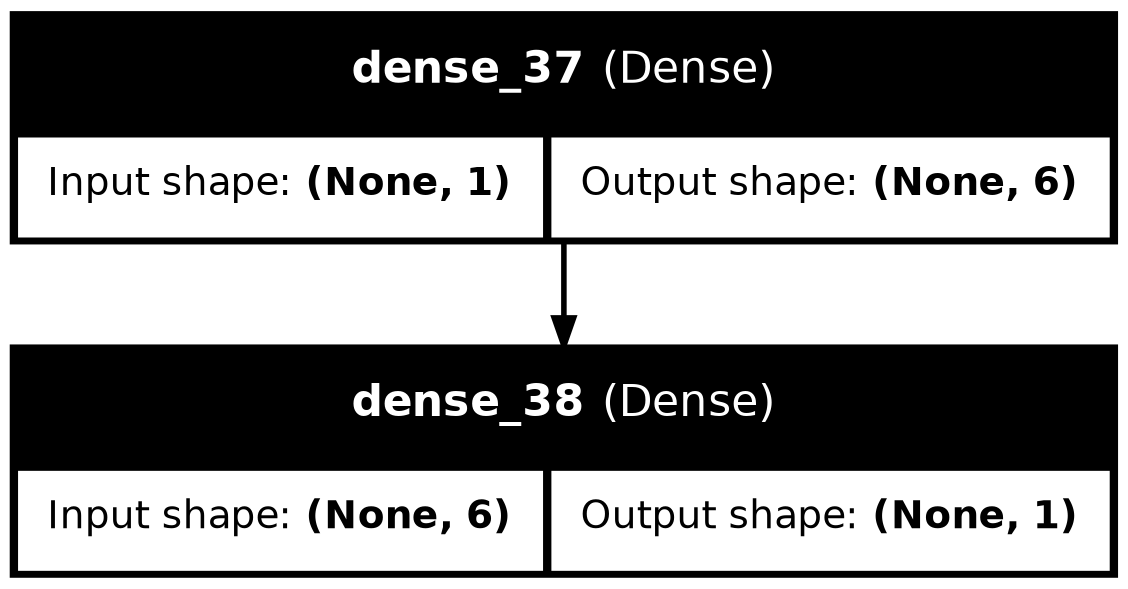

In [181]:
# Define the neural network model
tf.keras.utils.set_random_seed(1453)
model = keras.Sequential([
    layers.Input(shape=(1,)),               # input layer
    layers.Dense(6, activation='relu'),     # hidden layer
    layers.Dense(1, activation='linear')    # output layer
    ])

# Graph illustrating the network structure
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

We can write down the equations of all neurons, the superscripts of the weights and biases indicate which layer they are in, where layer 1 is the hidden layer and layer 2 is the output layer. For the $i$th neuron in the hidden layer it takes an input $x$ and outputs $y_i$ to the output layer through:
\begin{align}
z_i &= w^{(1)}_i x + b^{(1)}_i \\
y_i &= \max(0, z_i)
\end{align}
The only neuron in the output layer then takes the input $y_i$ from 5 neurons in the hidden layer and outputs the final prediction $\hat{y}$ through:
\begin{align}
\hat{y} = \sum^5_{i=1} w^{(2)}_i y_i + b^{(2)}
\end{align}
The loss function is then:
\begin{align}
L = \frac{1}{2} (y - \hat{y})^2
\end{align}
Where $y$ is the true target value of the object. We can then back propagate the gradient of all free parameters, for the output layer:
\begin{align}
\frac{\partial L}{\partial \hat{y}} &= (\hat{y} - y) \\
\frac{\partial L}{\partial w^{(2)}_i} &= \frac{\partial L}{\partial \hat{y}} \frac{\partial \hat{y}}{\partial w^{(2)}_i} = y_i(\hat{y} - y) \\
\frac{\partial L}{\partial b^{(2)}} &= \frac{\partial L}{\partial \hat{y}} \frac{\partial \hat{y}}{\partial b^{(2)}_i} = (\hat{y} - y)
\end{align}
For the hidden layer:
\begin{align}
\frac{\partial L}{\partial y_i} &= \frac{\partial L}{\partial \hat{y}} \frac{\partial \hat{y}}{\partial y_i} = (\hat{y} - y) w^{(2)}_i \\
\frac{\partial L}{\partial z_i} &= \frac{\partial L}{\partial y_i} \frac{\partial y_i}{\partial z_i} = (\hat{y} - y) w^{(2)}_i H(z_i) \\
\frac{\partial L}{\partial w^{(1)}_i} &= \frac{\partial L}{\partial z_i} \frac{\partial z_i}{\partial w^{(1)}_i} = (\hat{y} - y) w^{(2)}_i H(z_i) x \\
\frac{\partial L}{\partial b^{(1)}_i} &= \frac{\partial L}{\partial z_i} \frac{\partial z_i}{\partial b^{(1)}_i} = (\hat{y} - y) w^{(2)}_i H(z_i)
\end{align}
Where $H(z_i)$ is the Heaviside step function representing the derivative of the ReLU activation function:
\begin{align}
H(z_i) = \begin{cases}
    1, & z_i \geq 0 \\
    0, & z_i < 0
    \end{cases}
\end{align}

### Network Training

In [182]:
# Define training function
def train_model(model, x_train, y_train, lr, epochs=10):
    # Define optimizer and loss function
    optimizer = keras.optimizers.Adam(learning_rate=lr)
    loss_function = keras.losses.MeanSquaredError()
    
    # Loop over epochs and save training history
    history = []
    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            y_pred = model(x_train, training=True)
            loss = loss_function(y_train, y_pred)
        grad = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grad, model.trainable_variables))

        row = {"epoch": epoch + 1,
               "output": float(tf.reduce_mean(y_pred).numpy()),
               "loss": float(loss.numpy())}

        layer_index = 0
        for w, g in zip(model.trainable_variables, grad):
            if len(w.shape) == 1:  # skip bias
                continue

            w_flat = w.numpy().flatten()
            g_flat = g.numpy().flatten()
            for i, (wv, gv) in enumerate(zip(w_flat, g_flat)):
                # name by layer and neuron index
                row[f"w_layer{layer_index+1}_{i+1}"] = wv
                row[f"g_layer{layer_index+1}_{i+1}"] = gv
            layer_index += 1
        
        history.append(row)

    return pd.DataFrame(history)

We now train the model for 10 epochs and record the weights, gradients, outputs and loss at each epoch. The results are shown in the tables below, with the output and loss being the average over all sample, and the weights and gradients are numbered to indicate their location in the network, where layer 1 is the hidden layer and layer 2 is the output layer.

,epoch,output,loss,w_layer1_1,g_layer1_1,w_layer1_2,g_layer1_2,w_layer1_3,g_layer1_3,w_layer1_4,g_layer1_4,w_layer1_5,g_layer1_5,w_layer1_6,g_layer1_6,w_layer2_1,g_layer2_1,w_layer2_2,g_layer2_2,w_layer2_3,g_layer2_3,w_layer2_4,g_layer2_4,w_layer2_5,g_layer2_5,w_layer2_6,g_layer2_6
0,1,-0.072266,14.034164,0.665914,-0.069342,0.166391,0.150583,0.353451,1.935117,-0.458459,0.0,0.678593,-0.575136,-0.463939,0.0,0.132423,-1.210287,0.029588,-0.569703,-0.804845,-0.969757,-0.446964,0.0,0.368927,-1.237394,0.337063,0.0
1,2,0.231026,11.849975,0.755145,-0.258386,0.101579,-0.004379,0.259472,1.019902,-0.458459,0.0,0.778552,-0.719857,-0.463939,0.0,0.230824,-1.987774,0.097062,-0.003602,-0.728658,-0.128253,-0.446964,0.0,0.467408,-2.012522,0.337063,0.0
2,3,0.489163,10.142106,0.846242,-0.413472,0.051479,0.000000,0.186125,0.024148,-0.458459,0.0,0.878697,-0.837264,-0.463939,0.0,0.329261,-2.557191,0.149220,0.000000,-0.669714,-0.000776,-0.446964,0.0,0.565697,-2.667844,0.337063,0.0
3,4,0.780616,8.375179,0.939567,-0.532502,0.010441,0.000000,0.126043,0.000000,-0.458459,0.0,0.979211,-0.914880,-0.463939,0.0,0.428262,-2.989175,0.191944,0.000000,-0.621431,0.000000,-0.446964,0.0,0.664493,-3.156911,0.337063,0.0
4,5,1.121686,6.525733,1.035075,-0.605460,-0.024246,0.000000,0.075261,0.000000,-0.458459,0.0,1.080144,-0.939434,-0.463939,0.0,0.528076,-3.233389,0.228056,0.000000,-0.580621,0.000000,-0.446964,0.0,0.764130,-3.428274,0.337063,0.0
5,6,1.513900,4.690081,1.132537,-0.622996,-0.054142,0.000000,0.031493,0.000000,-0.458459,0.0,1.181296,-0.901481,-0.463939,0.0,0.628688,-3.245206,0.259180,0.000000,-0.545447,0.000000,-0.446964,0.0,0.864620,-3.439873,0.337063,0.0
6,7,1.957881,2.987972,1.231359,-0.575144,-0.080250,0.000000,-0.006730,0.000000,-0.458459,0.0,1.282021,-0.790981,-0.463939,0.0,0.729680,-2.977926,0.286361,0.000000,-0.514731,0.000000,-0.446964,0.0,0.965536,-3.148261,0.337063,0.0
7,8,2.452145,1.562559,1.330070,-0.452321,-0.103266,0.000000,-0.040426,0.000000,-0.458459,0.0,1.380813,-0.598525,-0.463939,0.0,0.829858,-2.386964,0.310322,0.000000,-0.487652,0.000000,-0.446964,0.0,1.065654,-2.513198,0.337063,0.0
8,9,2.990256,0.573082,1.425107,-0.247941,-0.123697,0.000000,-0.070339,0.000000,-0.458459,0.0,1.474507,-0.318391,-0.463939,0.0,0.926414,-1.440952,0.331593,0.000000,-0.463613,0.000000,-0.446964,0.0,1.162135,-1.509748,0.337063,0.0
9,10,3.554552,0.165019,1.508653,0.035113,-0.141932,0.000000,-0.097035,0.000000,-0.458459,0.0,1.557169,0.044048,-0.463939,0.0,1.013526,-0.150302,0.350578,0.000000,-0.442159,0.000000,-0.446964,0.0,1.249175,-0.157489,0.337063,0.0


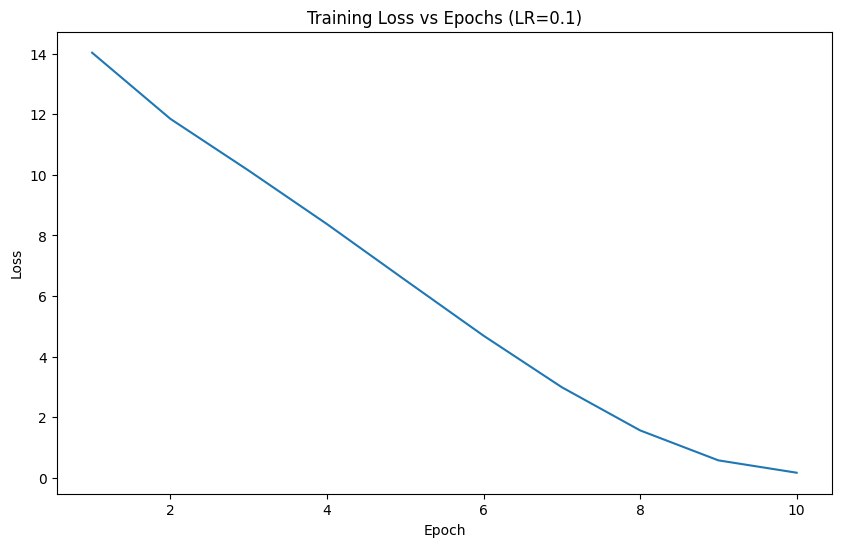

In [183]:
# Train for learning rate 0.1
model0 = keras.models.clone_model(model)
history = train_model(model0, x, y, 0.1, epochs=10)
display(history)

plt.figure(figsize=(10,6))
plt.plot(history['epoch'], history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs Epochs (LR=0.1)')
plt.show()

The loss decreases monotonically when learning rate is 0.1.

,epoch,output,loss,w_layer1_1,g_layer1_1,w_layer1_2,g_layer1_2,w_layer1_3,g_layer1_3,w_layer1_4,g_layer1_4,w_layer1_5,g_layer1_5,w_layer1_6,g_layer1_6,w_layer2_1,g_layer2_1,w_layer2_2,g_layer2_2,w_layer2_3,g_layer2_3,w_layer2_4,g_layer2_4,w_layer2_5,g_layer2_5,w_layer2_6,g_layer2_6
0,1,0.178125,12.220975,-0.61948,0.0,0.149635,0.507511,-0.483369,0.0,0.992555,-1.694897,0.551683,-1.149728,-0.138802,0.0,-0.646164,0.0,0.041596,-0.883096,0.385244,0.0,1.162960,-1.360213,0.885384,-0.494321,0.116645,0.0
1,2,1.379851,5.300141,-0.61948,0.0,-0.051379,0.000000,-0.483369,0.0,1.290414,-1.448665,0.851289,-1.102898,-0.138802,0.0,-0.646164,0.0,0.242610,0.000000,0.385244,0.0,1.453784,-2.612426,1.149298,-2.063243,0.116645,0.0
2,3,2.958687,0.643257,-0.61948,0.0,-0.206764,0.000000,-0.483369,0.0,1.553760,-0.445337,1.118805,-0.352064,-0.138802,0.0,-0.646164,0.0,0.397996,0.000000,0.385244,0.0,1.735632,-1.250587,1.419142,-1.118157,0.116645,0.0
3,4,4.809980,1.603546,-0.61948,0.0,-0.334046,0.000000,-0.483369,0.0,1.647513,1.380630,1.199665,1.128875,-0.138802,0.0,-0.646164,0.0,0.525278,0.000000,0.385244,0.0,1.774857,3.213392,1.426478,2.880275,0.116645,0.0
4,5,5.494360,3.683252,-0.61948,0.0,-0.441628,0.000000,-0.483369,0.0,1.607242,2.123065,1.144668,1.706336,-0.138802,0.0,-0.646164,0.0,0.632861,0.000000,0.385244,0.0,1.668512,5.597342,1.298761,5.045994,0.116645,0.0
5,6,5.148387,2.470083,-0.61948,0.0,-0.534350,0.000000,-0.483369,0.0,1.507913,1.639965,1.033334,1.276540,-0.138802,0.0,-0.646164,0.0,0.725583,0.000000,0.385244,0.0,1.507788,4.496440,1.121886,3.986612,0.116645,0.0
6,7,4.417236,0.749358,-0.61948,0.0,-0.615325,0.000000,-0.483369,0.0,1.390996,0.816365,0.907092,0.607424,-0.138802,0.0,-0.646164,0.0,0.806558,0.000000,0.385244,0.0,1.333963,2.185571,0.934863,1.882226,0.116645,0.0
7,8,3.658450,0.118439,-0.61948,0.0,-0.686709,0.000000,-0.483369,0.0,1.283625,0.112776,0.791883,0.079036,-0.138802,0.0,-0.646164,0.0,0.877942,0.000000,0.385244,0.0,1.179156,0.092914,0.768963,0.053225,0.116645,0.0
8,9,3.061202,0.445077,-0.61948,0.0,-0.750079,0.000000,-0.483369,0.0,1.200943,-0.324665,0.700300,-0.211723,-0.138802,0.0,-0.646164,0.0,0.941312,0.000000,0.385244,0.0,1.064430,-1.281844,0.643700,-1.085023,0.116645,0.0
9,10,2.684235,1.023390,-0.61948,0.0,-0.806635,0.000000,-0.483369,0.0,1.147789,-0.535909,0.634787,-0.324084,-0.138802,0.0,-0.646164,0.0,0.997869,0.000000,0.385244,0.0,0.996749,-2.006588,0.564369,-1.634613,0.116645,0.0


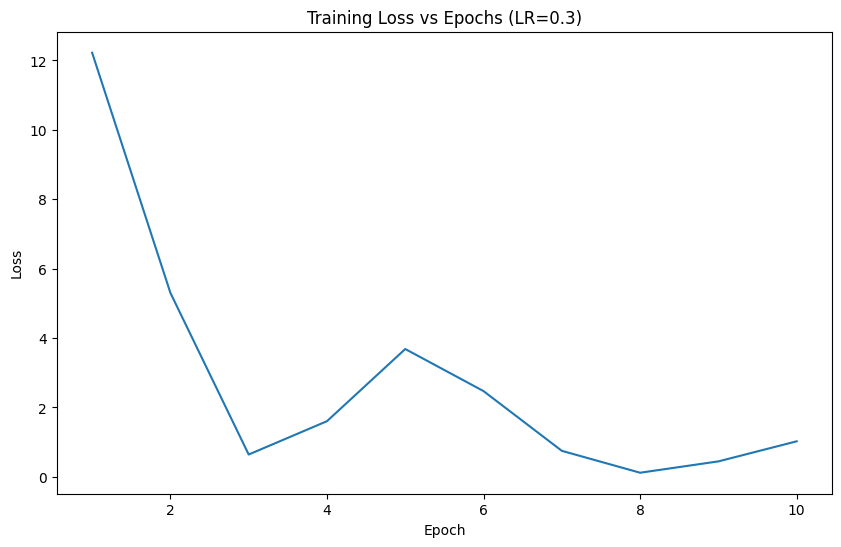

In [184]:
# Train for learning rate 0.3
model1 = keras.models.clone_model(model)
history_ = train_model(model1, x, y, 0.3)
display(history_)

plt.figure(figsize=(10,6))
plt.plot(history_['epoch'], history_['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs Epochs (LR=0.3)')
plt.show()

The loss can increase within 10 steps when the learning rate is larger than 0.1.